In [1]:
%load_ext autoreload
%autoreload 2

# Regions bounded by a series of named sections

In [2]:
from sectionate import Section, join_sections, convergent_transport
from regionate import BoundedRegion

### 1. Load data

In [3]:
from load_example_model_grid import load_MOM6_zint_heat_budget
grid = load_MOM6_zint_heat_budget()
ds = grid._ds

# Thermdynamic constants used in Boussinesq heat budget
rho0 = 1035. # kg/m^3
Cp = 3992. # J/kg/K

File 'MOM6_global_example_vertically_integrated_heat_budget_v0_0_6.nc' already exists at ../data/MOM6_global_example_vertically_integrated_heat_budget_v0_0_6.nc. Skipping download.


### 2. Define the `BoundedRegion`

We consider the rectangular Niño 3.4 region (170º-120ºW and 5ºS-5ºS), which is bounded by four straight segments.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# By default, sectionate creates sectionates between two points by following great circles;
# thus, to make a box that follows constant longitude or latitude lines, we need to add some
# intermediate points along each segment
N = 4
lons = [-170, -120]
lats = [-5, 5]
south_pacific_boundaries = [
    Section("southern", [(lon,  lats[0]) for lon in np.linspace(lons[0], lons[1], N)]),
    Section("western",  [(lons[0],  lat) for lat in np.linspace(lats[0], lats[1], N)]),
    Section("northern", [(lon,  lats[1]) for lon in np.linspace(lons[0], lons[1], N)]),
    Section("eastern",  [(lons[1],  lat) for lat in np.linspace(lats[0], lats[1], N)]),
]

section = join_sections("south pacific", *south_pacific_boundaries)

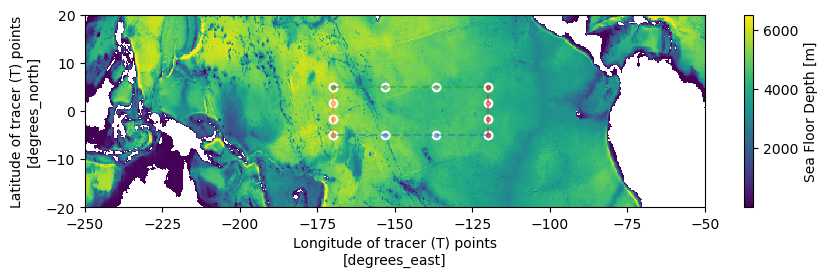

In [5]:
plt.figure(figsize=(10, 2.5))
# Plot seafloor depth for reference
ds.deptho.where(ds.deptho!=0).plot(x="geolon", y="geolat")

# Plot boundary of the region
plt.plot(section.lons_c, section.lats_c, "o", color="w")

# Plot each child section that makes up the bounded region
for child in section.children.values():
    plt.plot(child.lons_c, child.lats_c, ".", linestyle="--", alpha=0.5)

plt.ylim(-20, 20);
plt.xlim(-250, -50);

In [6]:
region = BoundedRegion(section, grid);

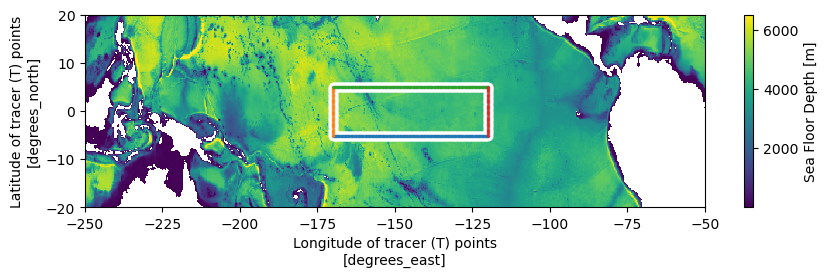

In [7]:
plt.figure(figsize=(10, 2.5))
# Plot seafloor depth for reference
ds.deptho.where(ds.deptho!=0).plot(x="geolon", y="geolat")

# Plot boundary of the region
plt.plot(region.lons_c, region.lats_c, "o", color="w")

# Plot each child section that makes up the bounded region
for child in region.children.values():
    plt.plot(child.lons_c, child.lats_c, ".", markersize=3, linestyle="--", alpha=0.5)

plt.ylim(-20, 20);
plt.xlim(-250, -50);

###

### 3. Use the `BoundedRegion`'s mask to compute the net heat flux convergence

In [8]:
dheatdt_dynamics = (ds['T_advection_xy']*ds['areacello']).sum('z_l')
dheatdt_dynamics = dheatdt_dynamics.where(dheatdt_dynamics!=0.).where(region.mask)
advective_heating_rate = dheatdt_dynamics.sum(["xh", "yh"]).isel(time=0).values

### 4. Use the grid indices of the `BoundedRegion`'s boundary to compute convergent heat fluxes along the boundary

In [9]:
convergent_heat_transport = convergent_transport(
    grid,
    region.i_c,
    region.j_c,
    utr="T_adx",
    vtr="T_ady",
    layer="z_l",
    interface="z_i",
    outname="conv_heat_transport",
    positive_in=region.mask,
).conv_heat_transport


A visualization demonstrates that the normal fluxes along the boundary are highly variable, especially depending on whether the normal flux is zonal or meridional!

Text(0, 0.5, 'convergent heat transport per grid face [W]')

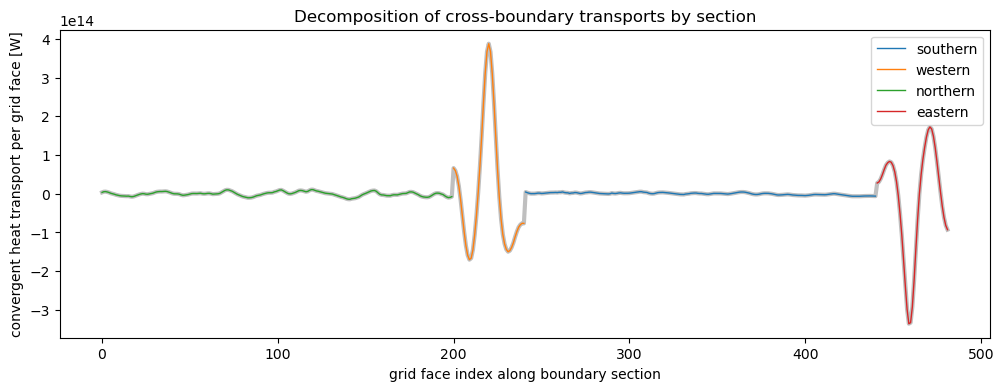

In [10]:
plt.figure(figsize=(12, 4))
# Plot the heat transport along the boundary
convergent_heat_transport.plot(lw=3, color="k", alpha=0.25)

# Plot heat transport along each child section that makes up the bounded region
for child in region.children.values():
    plt.plot(
        convergent_heat_transport.sect.isel(sect=child.parent_idx_uv),
        convergent_heat_transport.isel(sect=child.parent_idx_uv).squeeze(),
        linestyle="-", lw=1, label=child.name
    )
plt.title("Decomposition of cross-boundary transports by section")
plt.legend()
plt.xlabel("grid face index along boundary section")
plt.ylabel("convergent heat transport per grid face [W]")

While it visually looks like our four "child" sections that make up the "parent" section that is the entire closed region boundary, we can check that the sum of the children indeed recovers the total heat transport into the boundary.

In [11]:
convergent_heat_transport_children_sum = 0.
for child in region.children.values():
    convergent_heat_transport_children_sum += convergent_heat_transport.isel(sect=child.parent_idx_uv).sum()

complete_coverage_of_child_sections = np.isclose(convergent_heat_transport.sum(), convergent_heat_transport_children_sum, rtol=1e-5)

print(f"Check whether the sum of children equals the parent: {complete_coverage_of_child_sections}")

Check whether the sum of children equals the parent: True


### 5. Testing that our methods satisfy the divergence theorem on the model grid

In [12]:
budget_closes = np.isclose(advective_heating_rate, convergent_heat_transport_children_sum)
print(f"Check that the integral of the heat flux convergence on the interior mask is equal to the integral of the convergent flux along the boundary: {complete_coverage_of_child_sections}")

Check that the integral of the heat flux convergence on the interior mask is equal to the integral of the convergent flux along the boundary: True


By plotting each of the boundary fluxes alongside the advective heat flux convergence in the interior, we see that the net advective cooling of the Niño 3.4 region over the course of this year is due to the small residual of large compensating zonal fluxes.

/var/folders/bx/qc2zqzmj6fn43b6pscs_6hsc0000gn/T/ipykernel_63962/623782134.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


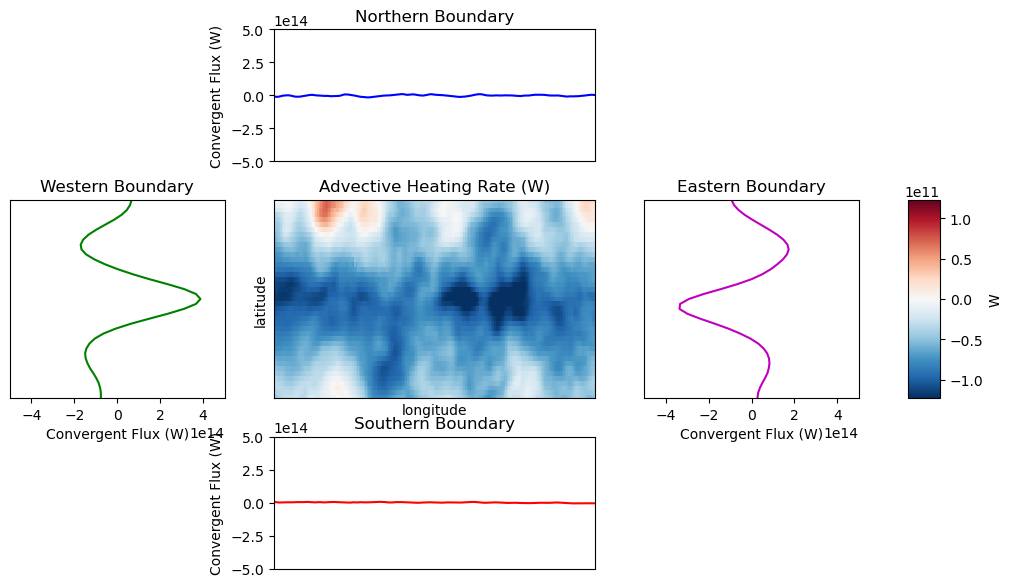

In [13]:
fig = plt.figure(figsize=(12, 7))
gs = fig.add_gridspec(
    3, 4,
    width_ratios=[2., 3, 2., 0.3],  # Make all line plots (columns 0, 2) bigger, map (column 1) smaller
    height_ratios=[2, 3, 2],        # Make top/bottom line plots (rows 0, 2) bigger, map (row 1) smaller
    wspace=0.25, hspace=0.25
)

# Main map
ax_map = fig.add_subplot(gs[1, 1])
im = dheatdt_dynamics.plot(ax=ax_map, x="geolon", y="geolat", robust=True, add_colorbar=False)
ax_map.set_xlim(*lons)
ax_map.set_ylim(*lats)
ax_map.set_xlabel("longitude")
ax_map.set_ylabel("latitude")
ax_map.set_title("Advective Heating Rate (W)")

# Add colorbar in its own axis
ax_cbar = fig.add_subplot(gs[1, 3])
cbar = fig.colorbar(im, cax=ax_cbar, orientation='vertical')
cbar.set_label("W")

# Top profile (northern boundary)
ax_top = fig.add_subplot(gs[0, 1], sharex=ax_map)
north_idx = region.children['northern'].parent_idx_uv
ax_top.plot(convergent_heat_transport.lon.isel(sect=north_idx), convergent_heat_transport.isel(sect=north_idx).squeeze(), color='b')
ax_top.set_ylabel("Convergent Flux (W)")
ax_top.set_xticks([])
ax_top.set_ylim(-5e14, 5e14)
ax_top.set_title("Northern Boundary")

# Bottom profile (southern boundary)
ax_bottom = fig.add_subplot(gs[2, 1], sharex=ax_map)
south_idx = region.children['southern'].parent_idx_uv
ax_bottom.plot(convergent_heat_transport.lon.isel(sect=south_idx), convergent_heat_transport.isel(sect=south_idx).squeeze(), color='r')
ax_bottom.set_ylabel("Convergent Flux (W)")
ax_bottom.set_xticks([])
ax_bottom.set_ylim(-5e14, 5e14)
ax_bottom.set_title("Southern Boundary")

# Left profile (western boundary)
ax_left = fig.add_subplot(gs[1, 0], sharey=ax_map)
west_idx = region.children['western'].parent_idx_uv
ax_left.plot(convergent_heat_transport.isel(sect=west_idx).squeeze(), convergent_heat_transport.lat.isel(sect=west_idx), color='g')
ax_left.set_xlabel("Convergent Flux (W)")
ax_left.set_yticks([])
ax_left.set_xlim(-5e14, 5e14)
ax_left.set_title("Western Boundary")

# Right profile (eastern boundary)
ax_right = fig.add_subplot(gs[1, 2], sharey=ax_map)
east_idx = region.children['eastern'].parent_idx_uv
ax_right.plot(convergent_heat_transport.isel(sect=east_idx).squeeze(), convergent_heat_transport.lat.isel(sect=east_idx), color='m')
ax_right.set_xlabel("Convergent Flux (W)")
ax_right.set_yticks([])
ax_right.set_xlim(-5e14, 5e14)
ax_right.set_title("Eastern Boundary")

plt.tight_layout()
plt.show()